In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np

In [2]:
class RelMultiHeadAttn(nn.Module):
    def __init__(self, n_head, d_model, d_head, dropout, dropatt=0,
                 tgt_len=None, ext_len=None, mem_len=None, pre_lnorm=False):
        super(RelMultiHeadAttn, self).__init__()

        self.n_head = n_head
        self.d_model = d_model
        self.d_head = d_head
        self.dropout = dropout

        self.q_net = nn.Linear(d_model, n_head * d_head, bias=False)
        self.k_net = nn.Linear(d_model, n_head * d_head, bias=False)
        self.v_net = nn.Linear(d_model, n_head * d_head, bias=False)

        self.drop = nn.Dropout(dropout)
        self.dropatt = nn.Dropout(dropatt)
        self.o_net = nn.Linear(n_head * d_head, d_model, bias=False)

        self.layer_norm = nn.LayerNorm(d_model)

        self.scale = 1 / (d_head ** 0.5)

        self.pre_lnorm = pre_lnorm

    def _parallelogram_mask(self, h, w, left=False):
        mask = torch.ones((h, w)).byte()
        m = min(h, w)
        mask[:m,:m] = torch.triu(mask[:m,:m])
        mask[-m:,-m:] = torch.tril(mask[-m:,-m:])

        if left:
            return mask
        else:
            return mask.flip(0)

    def _shift(self, x, qlen, klen, mask, left=False):
        if qlen > 1:
            zero_pad = torch.zeros((x.size(0), qlen-1, x.size(2), x.size(3)),
                                    device=x.device, dtype=x.dtype)
        else:
            zero_pad = torch.zeros(0, device=x.device, dtype=x.dtype)

        if left:
            mask = mask.flip(1)
            x_padded = torch.cat([zero_pad, x], dim=1).expand(qlen, -1, -1, -1)
        else:
            x_padded = torch.cat([x, zero_pad], dim=1).expand(qlen, -1, -1, -1)

        x = x_padded.masked_select(mask[:,:,None,None]) \
                    .view(qlen, klen, x.size(2), x.size(3))

        return x

    def _rel_shift(self, x, zero_triu=False):
        zero_pad = torch.zeros((x.size(0), 1, *x.size()[2:]),
                               device=x.device, dtype=x.dtype)
        x_padded = torch.cat([zero_pad, x], dim=1)

        x_padded = x_padded.view(x.size(1) + 1, x.size(0), *x.size()[2:])

        x = x_padded[1:].view_as(x)

        if zero_triu:
            ones = torch.ones((x.size(0), x.size(1)))
            x = x * torch.tril(ones, x.size(1) - x.size(0))[:,:,None,None]

        return x

    def forward(self, w, r, attn_mask=None, mems=None):
        raise NotImplementedError

In [3]:
class RelPartialLearnableMultiHeadAttn(RelMultiHeadAttn):
    def __init__(self, *args, **kwargs):
        super(RelPartialLearnableMultiHeadAttn, self).__init__(*args, **kwargs)

        self.r_net = nn.Linear(self.d_model, self.n_head * self.d_head, bias=False)

    def forward(self, q, k, v, r, r_w_bias, r_r_bias, attn_mask=None, mems=None):
        qlen, rlen, bsz_q, bsz_k, bsz_v = q.size(0), r.size(0), q.size(1), k.size(1), v.size(1)
        
        w_head_q = self.q_net(q)
        w_head_k = self.k_net(k)
        w_head_v = self.v_net(v)

        r_head_k = self.r_net(r)

        klen = w_head_k.size(0)

        w_head_q = w_head_q.view(qlen, bsz_q, self.n_head, self.d_head)           # qlen x bsz x n_head x d_head
        w_head_k = w_head_k.view(klen, bsz_k, self.n_head, self.d_head)           # qlen x bsz x n_head x d_head
        w_head_v = w_head_v.view(klen, bsz_v, self.n_head, self.d_head)           # qlen x bsz x n_head x d_head

        r_head_k = r_head_k.view(rlen, self.n_head, self.d_head)                # qlen x n_head x d_head

        #### compute attention score
        rw_head_q = w_head_q + r_w_bias                                         # qlen x bsz x n_head x d_head
        AC = torch.einsum('ibnd,ijnd->ibjn', (rw_head_q, w_head_k))             # qlen x klen x bsz x n_head

        rr_head_q = w_head_q + r_r_bias
        BD = torch.einsum('ibnd,ind->ibn', (rr_head_q, r_head_k))              # qlen x klen x bsz x n_head
        BD = self._rel_shift(BD)
        BD = torch.repeat_interleave(BD.unsqueeze(2), repeats=bsz_k, dim=2)

        # [qlen x klen x bsz x n_head]
        attn_score = AC + BD
        attn_score.mul_(self.scale)

        #### compute attention probability
        if attn_mask is not None and attn_mask.any().item():
            if attn_mask.dim() == 2:
                attn_score = attn_score.float().masked_fill(
                    attn_mask[None,:,:,None], -float('inf')).type_as(attn_score)
            elif attn_mask.dim() == 3:
                attn_score = attn_score.float().masked_fill(
                    attn_mask[:,:,:,None], -float('inf')).type_as(attn_score)

        # [qlen x klen x bsz x n_head]
        attn_prob = F.softmax(attn_score, dim=1)
        attn_prob = self.dropatt(attn_prob)

        #### compute attention vector
        attn_vec = torch.einsum('ibjn,ijnd->ibnd', (attn_prob, w_head_v))

        # [qlen x bsz x n_head x d_head]
        attn_vec = attn_vec.contiguous().view(
            attn_vec.size(0), attn_vec.size(1), self.n_head * self.d_head)

        ##### linear projection
        attn_out = self.o_net(attn_vec)
        attn_out = self.drop(attn_out)

        if self.pre_lnorm:
            ##### residual connection
            output = q + attn_out
        else:
            ##### residual connection + layer normalization
            output = self.layer_norm(q + attn_out)

        return output

In [4]:
class EncoderLayer(nn.Module):
    def __init__(self, num_heads, d_model, d_ff, dropout):
        super().__init__()

        self.dec_attn = RelPartialLearnableMultiHeadAttn(n_head=num_heads, d_model=d_model,
                            d_head=int(d_model/num_heads), dropout=dropout)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.positionwise_feedforward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout),
        )
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
        self.pos_emb = PositionalEmbedding(d_model)
        self.r_w_bias = nn.Parameter(torch.Tensor(num_heads, int(d_model/num_heads)))
        self.r_r_bias = nn.Parameter(torch.Tensor(num_heads, int(d_model/num_heads)))

    def forward(self, x, dec_attn_mask=None, mems=None):
        qlen, bsz, _ = x.size()
        klen = qlen
        pos_seq = torch.arange(klen-1, -1, -1.0)
        pos_emb = self.pos_emb(pos_seq)
               
        attention_output = self.dec_attn(x, x, x, pos_emb, self.r_w_bias, self.r_r_bias,
                               attn_mask=dec_attn_mask,
                               mems=mems)
        x = self.layer_norm1(x + self.dropout(attention_output))
        feedforward_output = self.positionwise_feedforward(x)
        x = self.layer_norm2(x + self.dropout(feedforward_output))
        return x

In [5]:
class PositionalEmbedding(nn.Module):
    def __init__(self, demb):
        super(PositionalEmbedding, self).__init__()

        self.demb = demb

        inv_freq = 1 / (10000 ** (torch.arange(0.0, demb, 2.0) / demb))
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, pos_seq, bsz=None):
        sinusoid_inp = torch.ger(pos_seq, self.inv_freq)
        pos_emb = torch.cat([sinusoid_inp.sin(), sinusoid_inp.cos()], dim=-1)

        if bsz is not None:
            return pos_emb[:,None,:].expand(-1, bsz, -1)
        else:
            return pos_emb[:,None,:]

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=20):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) #.transpose(0, 1)
        self.register_buffer('pe', pe)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = x + self.pe.repeat(x.size(0),1,1)
        x = self.dropout(x)
        return x

In [7]:
class Transformer_XL(nn.Module):
    def __init__(self, num_layers, num_heads, d_model, d_ff, dropout):
        super().__init__()

        self.positional_encoding = PositionalEncoding(d_model=d_model, dropout=dropout)

        self.encoder_layers = nn.ModuleList([EncoderLayer(num_heads=num_heads, d_model=d_model, d_ff=d_ff, dropout=dropout) for _ in range(num_layers)])
#        self.decoder_layers = nn.ModuleList([DecoderLayer(num_heads=num_heads, d_model=d_model, d_ff=d_ff, dropout=dropout) for _ in range(num_layers)])

        self.flatten = nn.Flatten()
        self.final_layer = nn.Linear(d_model, 1)
        
    def forward(self, input_ids):

        input_embeddings = input_ids

        # Apply positional encoding
        input_embeddings = self.positional_encoding(input_embeddings)

        # Encode inputs
        for layer in self.encoder_layers:
            input_embeddings = layer(input_embeddings)


        output=torch.mean(input_embeddings,dim=1,keepdim=False)
        output = F.relu(self.flatten(output))
        output = self.final_layer(output)
        
        return output

In [8]:
num_layers = 2
num_heads = 2
d_model = 22
d_ff = 64
dropout = 0
model = Transformer_XL(num_layers=num_layers, num_heads=num_heads, d_model=d_model, d_ff=d_ff, dropout=dropout)

input_ids = torch.rand(11,20,22)
output = model(input_ids)
print(output.shape)
print(output)

torch.Size([11, 1])
tensor([[-0.3096],
        [-0.3047],
        [-0.2858],
        [-0.4096],
        [-0.3106],
        [-0.2677],
        [-0.2980],
        [-0.1971],
        [-0.2055],
        [-0.3520],
        [-0.3917]], grad_fn=<AddmmBackward0>)


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [10]:
column_names = ['date','AOAL','AOAR','PITCH','W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE','TMAX','FS']

input=pd.read_excel('D:\\研究生毕设\\practice\\QAR_xunlian.xlsx',names=column_names)

In [11]:
feature_names = ['W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE']

df=input[feature_names]

In [12]:
df_for_training=df[feature_names].astype(float)

In [13]:
scaler=MinMaxScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [14]:
trainX=[]
trainY=[]

In [15]:
n_future=1
n_past=20

In [16]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i:i+n_future,21])

In [17]:
trainX,trainY=np.array(trainX),np.array(trainY)
print('trainX shape=={}.'.format(trainX.shape))
print('trainY shape=={}.'.format(trainY.shape))

trainX shape==(11504, 20, 22).
trainY shape==(11504, 1).


In [18]:
trainX_copy,trainY_copy=trainX.copy(),trainY.copy()

In [19]:
data,label=trainX,trainY

In [20]:
def standardization(data):
    mu = np.min(data)
    sigma = np.max(data)-np.min(data)
    return (data - mu) / sigma

In [21]:
for j in range(0,data.shape[2]):
    data[:,:,j]=standardization(data[:,:,j])

In [22]:
label=standardization(label)

In [23]:
data = torch.from_numpy(data).float()
label = torch.from_numpy(label).float()
train_dataset = TensorDataset(data,  label)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=False)

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
min_val_acc=1000000000000000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0 )
criterion = nn.L1Loss()

In [25]:
for epoch in range(1000):
    
    losses = []
    for batch_idx, (data1, targets) in enumerate(train_loader):
        #import pdb;pdb.set_trace()
        output = model(data1)
       
        loss = 10*criterion(output, targets)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
    
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)
    print('Epoch:', epoch, 'Loss:', loss.item())

    if mean_loss<min_val_acc:
        min_val_acc =mean_loss
        torch.save(model.state_dict(), 'best_cos_3-3.pth')

D:\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0 Loss: 1.0714571475982666
Epoch: 1 Loss: 0.837613582611084
Epoch: 2 Loss: 0.849575936794281
Epoch: 3 Loss: 0.810721755027771
Epoch: 4 Loss: 0.7749017477035522
Epoch: 5 Loss: 0.7420841455459595
Epoch: 6 Loss: 0.6907033920288086
Epoch: 7 Loss: 0.7053264379501343
Epoch: 8 Loss: 0.693089485168457
Epoch: 9 Loss: 0.664885401725769
Epoch: 10 Loss: 0.657690703868866
Epoch: 11 Loss: 0.6513955593109131
Epoch: 12 Loss: 0.6491378545761108
Epoch: 13 Loss: 0.6537938714027405
Epoch: 14 Loss: 0.6932156682014465
Epoch: 15 Loss: 0.6944315433502197
Epoch: 16 Loss: 0.6562991142272949
Epoch: 17 Loss: 0.6777690649032593
Epoch: 18 Loss: 0.6505969762802124
Epoch: 19 Loss: 0.7316761612892151
Epoch: 20 Loss: 0.6420042514801025
Epoch: 21 Loss: 0.6559669375419617
Epoch: 22 Loss: 0.6840332746505737
Epoch: 23 Loss: 0.6535632610321045
Epoch: 24 Loss: 0.6331440806388855
Epoch: 25 Loss: 0.657008945941925
Epoch: 26 Loss: 0.6486219763755798
Epoch: 27 Loss: 0.664348840713501
Epoch: 28 Loss: 0.6520228981971741
Epo

Epoch: 231 Loss: 0.34609830379486084
Epoch: 232 Loss: 0.309002161026001
Epoch: 233 Loss: 0.4233136475086212
Epoch: 234 Loss: 0.33309781551361084
Epoch: 235 Loss: 0.3519582748413086
Epoch: 236 Loss: 0.40775197744369507
Epoch: 237 Loss: 0.3422345221042633
Epoch: 238 Loss: 0.31171494722366333
Epoch: 239 Loss: 0.37883657217025757
Epoch: 240 Loss: 0.3227960467338562
Epoch: 241 Loss: 0.31608283519744873
Epoch: 242 Loss: 0.33879879117012024
Epoch: 243 Loss: 0.2939082980155945
Epoch: 244 Loss: 0.2923133373260498
Epoch: 245 Loss: 0.45421361923217773
Epoch: 246 Loss: 0.49888914823532104
Epoch: 247 Loss: 0.33974170684814453
Epoch: 248 Loss: 0.3802146911621094
Epoch: 249 Loss: 0.3656187951564789
Epoch: 250 Loss: 0.3333035707473755
Epoch: 251 Loss: 0.33441099524497986
Epoch: 252 Loss: 0.28803563117980957
Epoch: 253 Loss: 0.3852766752243042
Epoch: 254 Loss: 0.2895636558532715
Epoch: 255 Loss: 0.3151971101760864
Epoch: 256 Loss: 0.3197091519832611
Epoch: 257 Loss: 0.3201003670692444
Epoch: 258 Loss: 

Epoch: 456 Loss: 0.36346930265426636
Epoch: 457 Loss: 0.16778528690338135
Epoch: 458 Loss: 0.1947985291481018
Epoch: 459 Loss: 0.35409367084503174
Epoch: 460 Loss: 0.25199946761131287
Epoch: 461 Loss: 0.1793808490037918
Epoch: 462 Loss: 0.19524677097797394
Epoch: 463 Loss: 0.18550081551074982
Epoch: 464 Loss: 0.222208172082901
Epoch: 465 Loss: 0.16103647649288177
Epoch: 466 Loss: 0.2525844871997833
Epoch: 467 Loss: 0.22807858884334564
Epoch: 468 Loss: 0.23603323101997375
Epoch: 469 Loss: 0.19329798221588135
Epoch: 470 Loss: 0.2562740743160248
Epoch: 471 Loss: 0.18235692381858826
Epoch: 472 Loss: 0.19842392206192017
Epoch: 473 Loss: 0.16745305061340332
Epoch: 474 Loss: 0.25524693727493286
Epoch: 475 Loss: 0.17014551162719727
Epoch: 476 Loss: 0.2156585454940796
Epoch: 477 Loss: 0.15143725275993347
Epoch: 478 Loss: 0.19752895832061768
Epoch: 479 Loss: 0.2611410319805145
Epoch: 480 Loss: 0.20187748968601227
Epoch: 481 Loss: 0.1818467080593109
Epoch: 482 Loss: 0.2950993478298187
Epoch: 483 

Epoch: 680 Loss: 0.13066929578781128
Epoch: 681 Loss: 0.2372078001499176
Epoch: 682 Loss: 0.13666144013404846
Epoch: 683 Loss: 0.252890944480896
Epoch: 684 Loss: 0.12640437483787537
Epoch: 685 Loss: 0.16271637380123138
Epoch: 686 Loss: 0.15183252096176147
Epoch: 687 Loss: 0.19347244501113892
Epoch: 688 Loss: 0.12180834263563156
Epoch: 689 Loss: 0.20972691476345062
Epoch: 690 Loss: 0.10611683130264282
Epoch: 691 Loss: 0.3560324013233185
Epoch: 692 Loss: 0.20979298651218414
Epoch: 693 Loss: 0.15501099824905396
Epoch: 694 Loss: 0.2961415648460388
Epoch: 695 Loss: 0.1300441324710846
Epoch: 696 Loss: 0.24618758261203766
Epoch: 697 Loss: 0.17538219690322876
Epoch: 698 Loss: 0.1311463564634323
Epoch: 699 Loss: 0.20546633005142212
Epoch: 700 Loss: 0.16549384593963623
Epoch: 701 Loss: 0.15498577058315277
Epoch: 702 Loss: 0.10312653332948685
Epoch: 703 Loss: 0.2500544786453247
Epoch: 704 Loss: 0.11983832716941833
Epoch: 705 Loss: 0.32893407344818115
Epoch: 706 Loss: 0.1349993199110031
Epoch: 707

Epoch: 904 Loss: 0.0955851674079895
Epoch: 905 Loss: 0.14351220428943634
Epoch: 906 Loss: 0.14692258834838867
Epoch: 907 Loss: 0.14226195216178894
Epoch: 908 Loss: 0.13711312413215637
Epoch: 909 Loss: 0.0874219536781311
Epoch: 910 Loss: 0.12455160915851593
Epoch: 911 Loss: 0.10762934386730194
Epoch: 912 Loss: 0.09489680826663971
Epoch: 913 Loss: 0.1394890695810318
Epoch: 914 Loss: 0.09659162908792496
Epoch: 915 Loss: 0.13748912513256073
Epoch: 916 Loss: 0.19887736439704895
Epoch: 917 Loss: 0.16355492174625397
Epoch: 918 Loss: 0.13071517646312714
Epoch: 919 Loss: 0.16524137556552887
Epoch: 920 Loss: 0.21120308339595795
Epoch: 921 Loss: 0.1207321509718895
Epoch: 922 Loss: 0.18085969984531403
Epoch: 923 Loss: 0.14053860306739807
Epoch: 924 Loss: 0.12768518924713135
Epoch: 925 Loss: 0.11814640462398529
Epoch: 926 Loss: 0.12985152006149292
Epoch: 927 Loss: 0.12060492485761642
Epoch: 928 Loss: 0.1987893134355545
Epoch: 929 Loss: 0.10504184663295746
Epoch: 930 Loss: 0.09524698555469513
Epoch:

In [26]:
trainX_copy_=trainX_copy
trainY_copy_=trainY_copy

In [27]:
for j in range(0,trainX_copy_.shape[2]):
    trainX_copy_[:,:,j]=standardization(trainX_copy_[:,:,j])

In [28]:
trainY_copy_=standardization(trainY_copy_)

In [29]:
test_data = torch.from_numpy(trainX_copy_).float()
test_label = torch.from_numpy(trainY_copy_).float()
test_dataset = TensorDataset(test_data, test_label)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [30]:
predictions=[]
for batch_idx, (data, targets) in enumerate(test_loader):
    output=model(data)
    predictions+=output.tolist()

In [31]:
predictions = np.array(predictions)

In [32]:
trainY_copies1 = np.repeat(trainY_copy[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1)
trainY_1 = scaler.inverse_transform(trainY_copies1)[:,21]

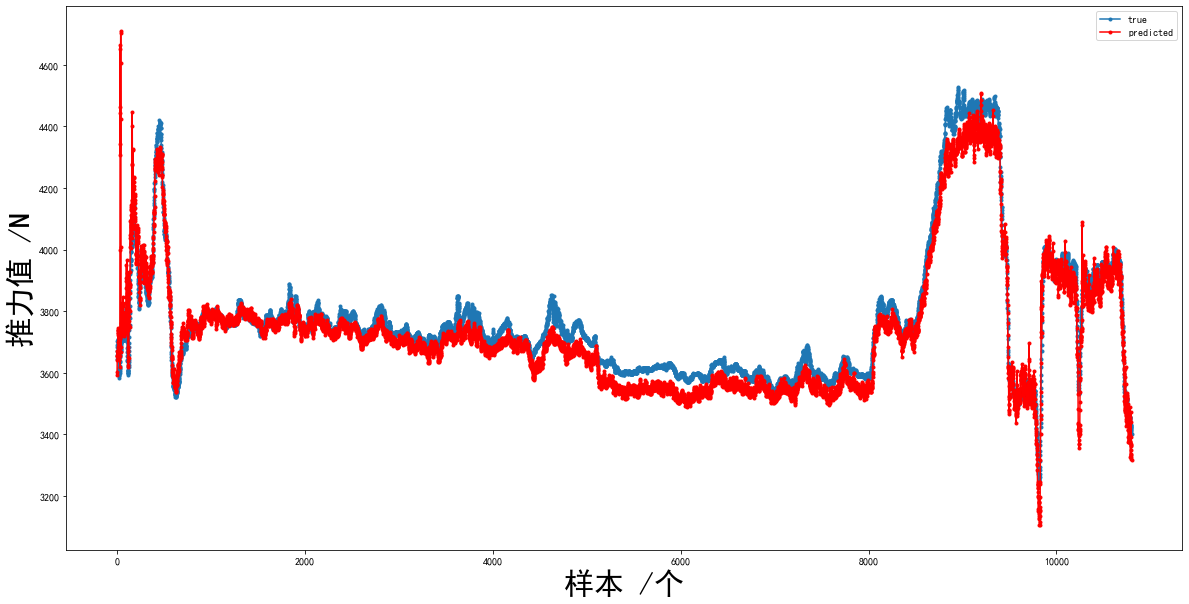

In [33]:
plt.figure(figsize=(20,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.xlabel('样本 /个',fontdict={ 'size'   : 30})
plt.ylabel('推力值 /N',fontdict={ 'size'   : 30})
plt.plot(trainY_1[200:11000],marker='.',label='true')
plt.plot((predictions*19043.454262518393+23.9856747376088)[200:11000],'r',marker='.',label='predicted')                  #sample的时刻是一致的
plt.legend(); 